In [1]:
import numpy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
import pandas as pd

## Merging two files so that we can do the analysis.
a = pd.read_csv("train_features.csv")
b = pd.read_csv("train_salaries.csv")

merged = a.merge(b, on='jobId')

merged.to_csv('result.csv', index=False)

In [35]:
df=pd.read_csv('result.csv',na_values='?')
df.dropna(inplace=True)
df.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [36]:
df.shape

(1000234, 9)

In [4]:
df = df.rename(columns={'jobId':'jobId', 'companyId':'companyId','jobType' :'jobType', 'degree':'degree', \
                        'major':'major','industry' :'industry', 'yearsExperience':'yearsExperience', 'milesFromMetropolis':'milesFromMetropolis', \
                        'salary':'salary'})

In [5]:
## Label encoding the categorical features. Did not use "jobId and "CompanyId"
from sklearn.preprocessing import LabelEncoder
cols = [ 'jobType', 'degree', 'major', 'industry']

for x in cols:
    lbl = LabelEncoder()
    df[x] = lbl.fit_transform(df[x])

In [6]:
df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

In [7]:
df.convert_objects(convert_numeric=True).dtypes

C:\Users\Akshay\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


jobId                  object
companyId              object
jobType                 int64
degree                  int64
major                   int64
industry                int64
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

## Data visualization

In [17]:
## Importing all the necessary libraries for visualization and feature importance
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

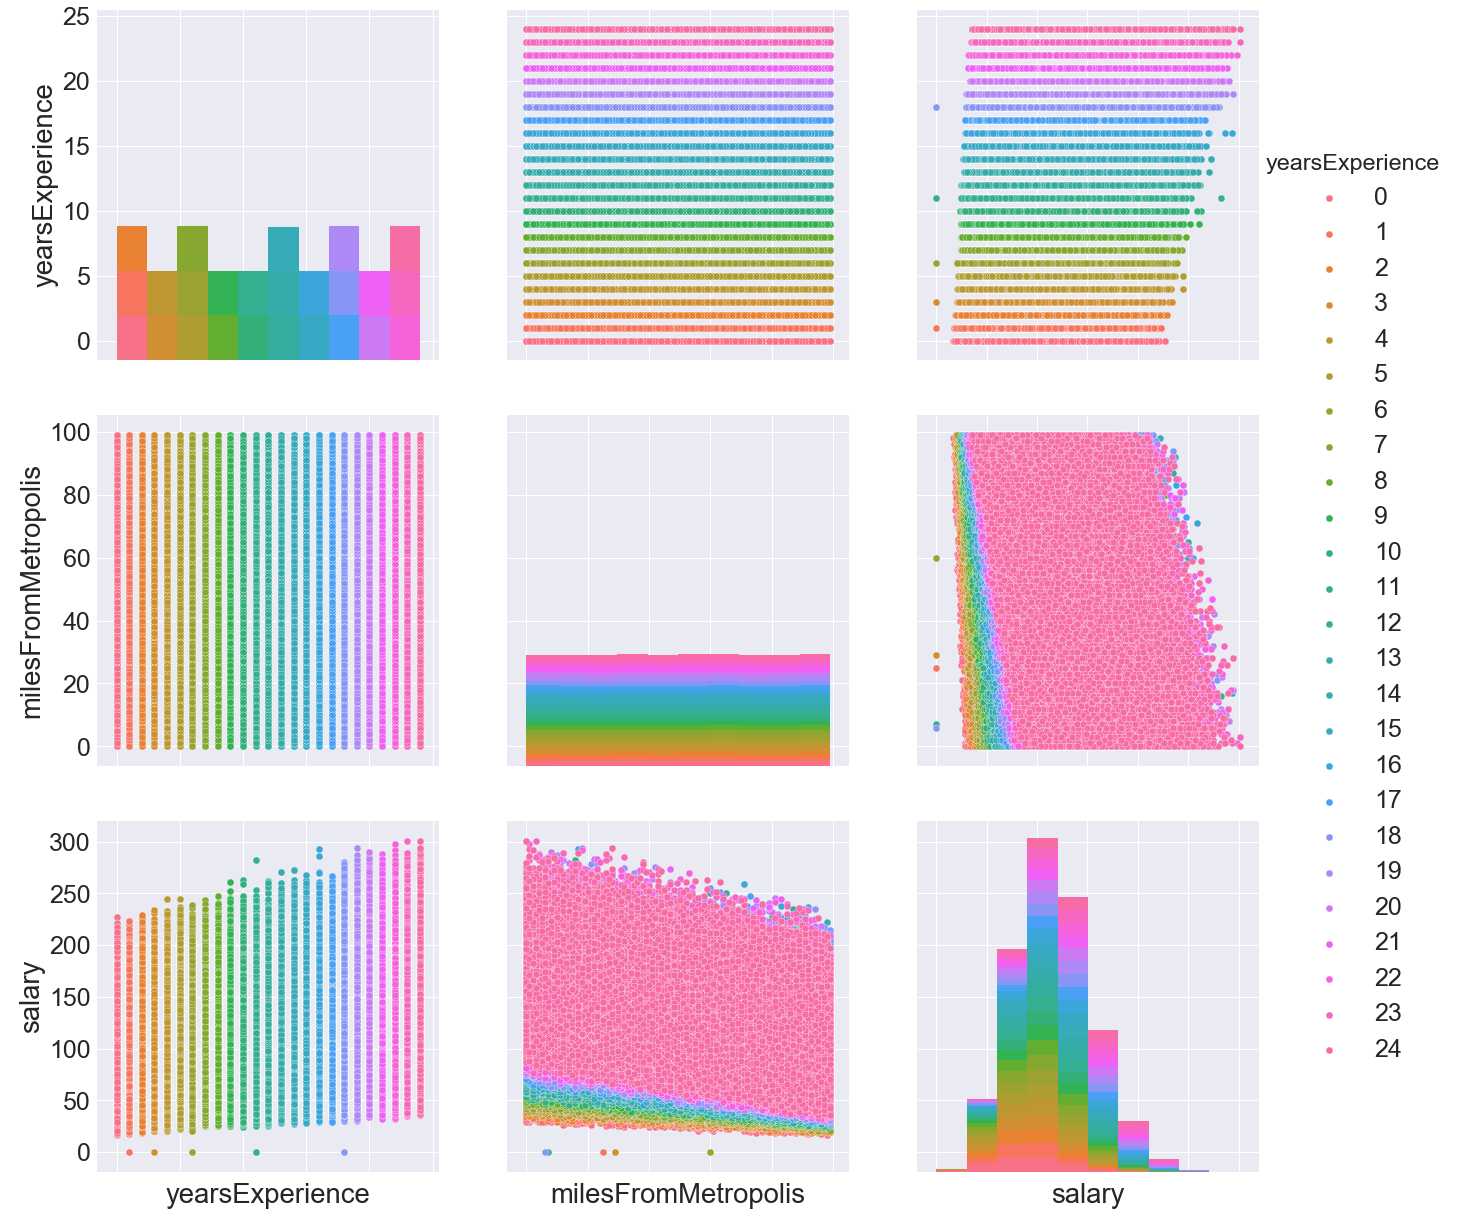

In [11]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['yearsExperience', 'milesFromMetropolis','salary']], 
                 hue='yearsExperience',size=6)
g.set(xticklabels=[]);

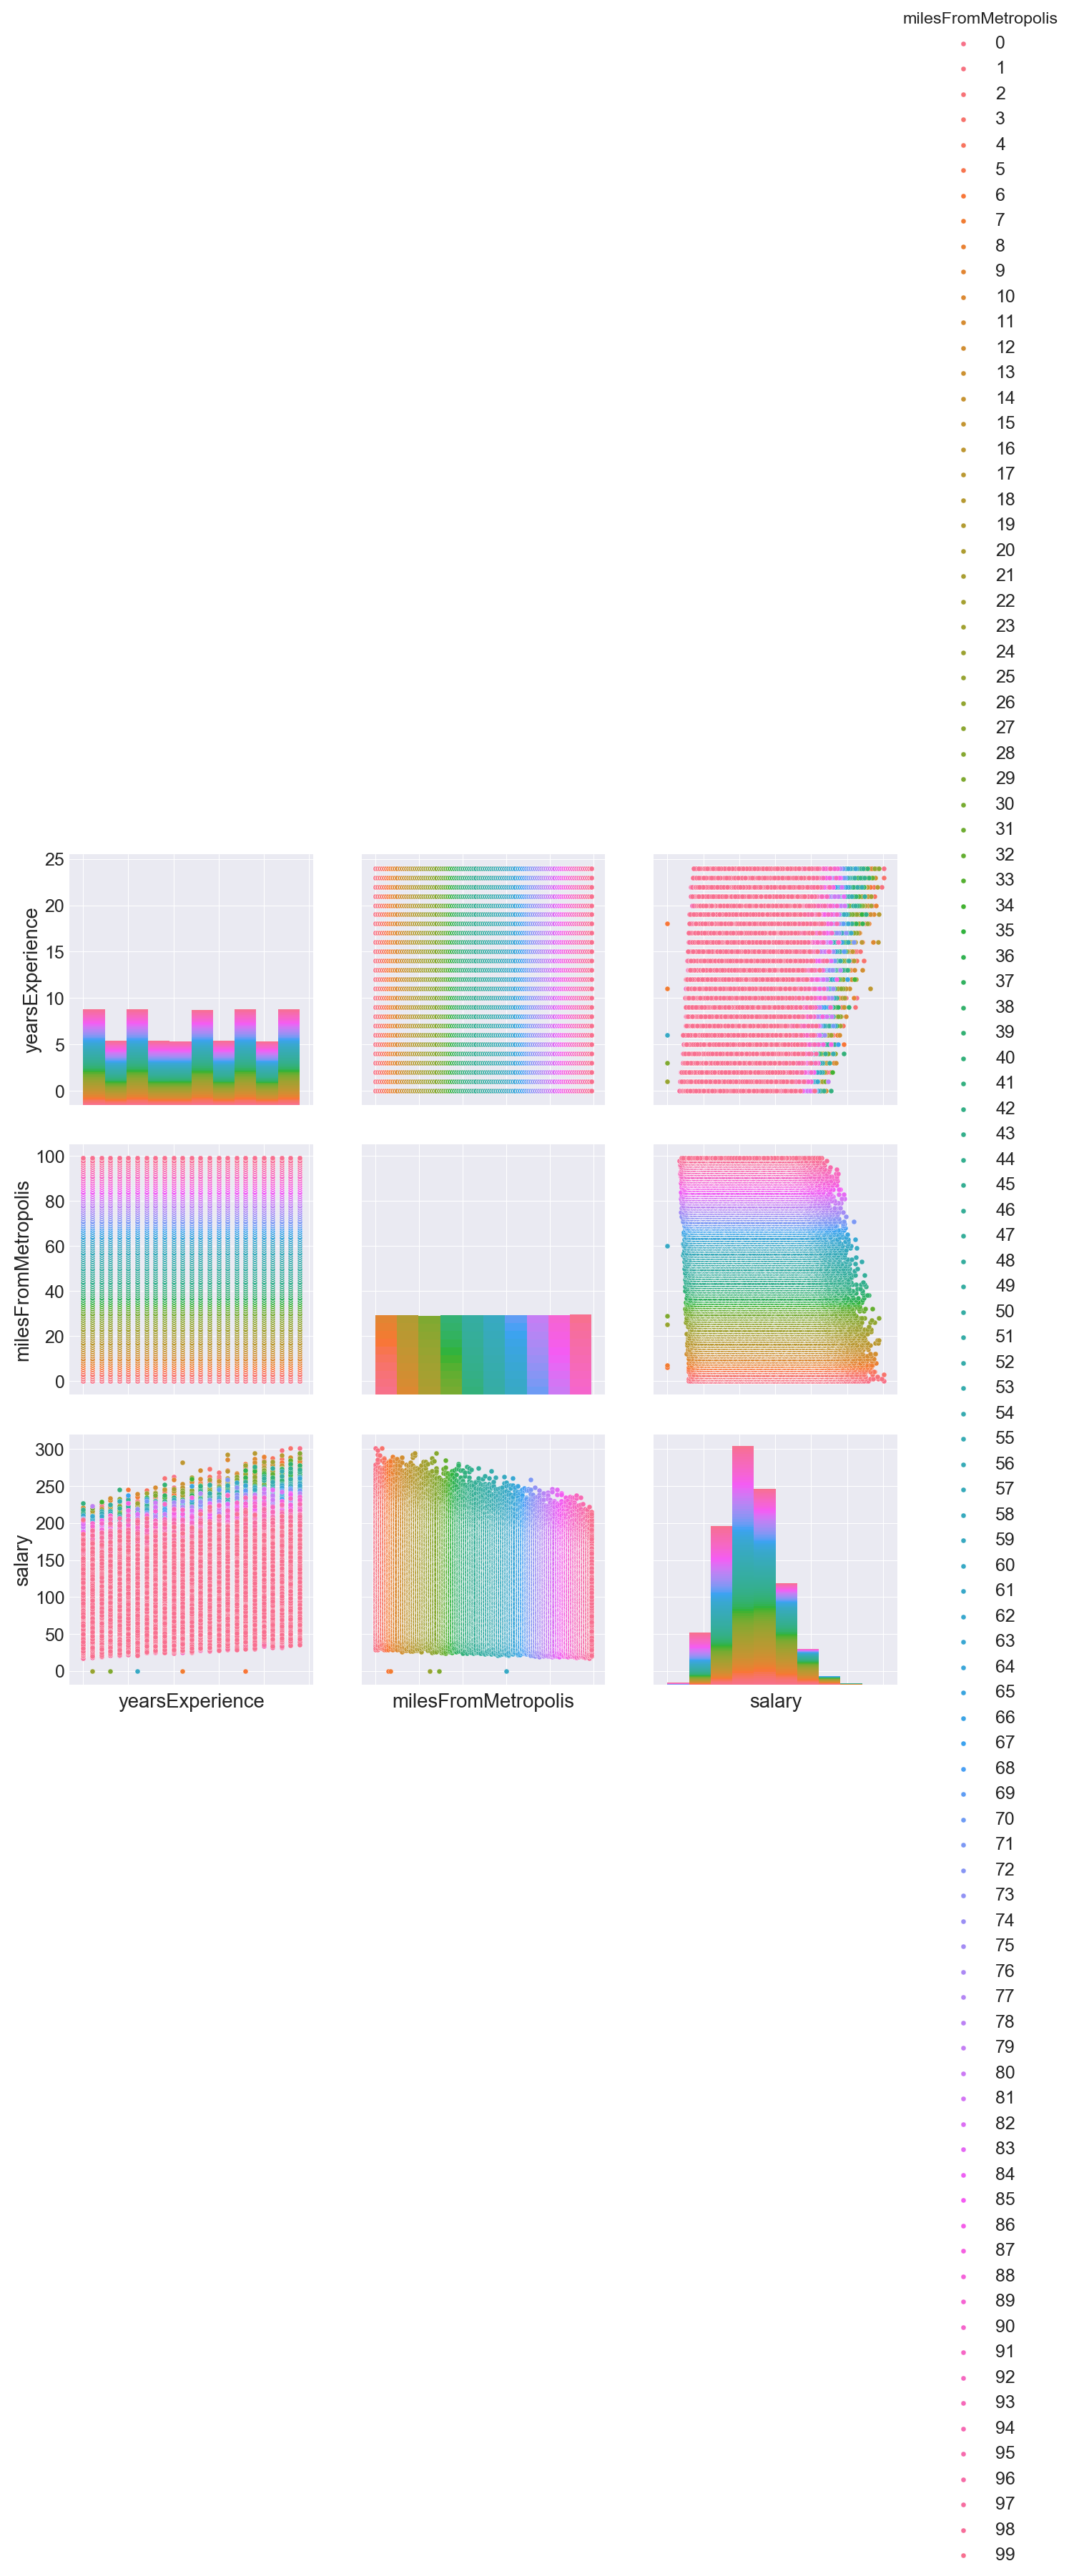

In [18]:
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(df[['yearsExperience', 'milesFromMetropolis','salary']], 
                 hue='milesFromMetropolis',size=6)
g.set(xticklabels=[]);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B97B90160>]], dtype=object)

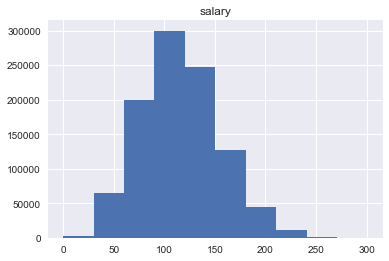

In [33]:
df[['salary']].hist() ## Checking the distribution of of our target variable i.e. salary.


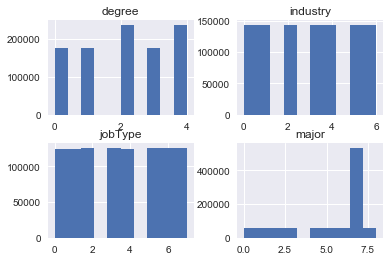

In [32]:
categorical_idx = df[['jobType', 'degree', 'major', 'industry']] ## For categorical features
plt.show()
categorical_idx.hist()
plt.show()


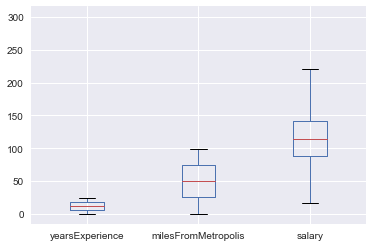

In [31]:
numerical_idx=df[['yearsExperience', 'milesFromMetropolis','salary']] ## For numerical features
numerical_idx.boxplot()
plt.show()

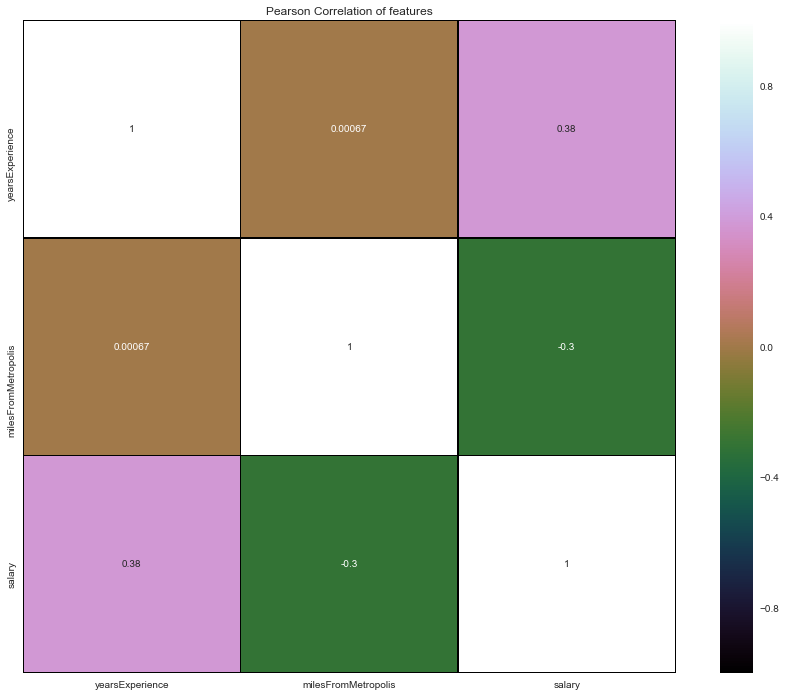

In [12]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list) 
# Create Dataframe containing only numerical features
num_fea= df[['yearsExperience', 'milesFromMetropolis','salary']]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
sns.heatmap(num_fea.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

In [53]:
## The above heat map clearly tells us that the linear association between salary and yearsExperience is stronger than milesfromMetropolis and salary.

## Feature Engineering Techniques

In [13]:
df1=df[['jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis','salary']]
Y = df1.salary.values
df1 = df1.drop(['salary'], axis=1)
X = df1.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = df1.columns

In [14]:
import numpy as np
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

## 1) Stability Selection via Randomized Lasso

In [15]:
rlasso = RandomizedLasso(alpha=0.01)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

finished


## 2) Recursive Feature Elimination ( RFE )

In [16]:
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


## 3) Linear Model Feature Ranking

In [17]:
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

## 4) Random Forest feature ranking

In [18]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

building tree 1 of 100building tree 3 of 100
building tree 2 of 100building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 8 of 100building tree 7 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   38.3s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


## Creating the Feature Ranking Matrix

In [19]:
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
jobType	0.9	0.9	1.0	0.8	0.9	0.0	0.75
degree	1.0	1.0	0.0	1.0	1.0	0.0	0.67
major	0.75	0.74	0.15	0.6	0.74	1.0	0.66
industry	0.32	0.32	0.17	0.2	0.32	0.0	0.22
yearsExperience	0.41	0.4	0.47	0.4	0.4	0.94	0.5
milesFromMetropolis	0.0	0.0	0.51	0.0	0.0	0.81	0.22


In [20]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

## Visualizing the mean ranking

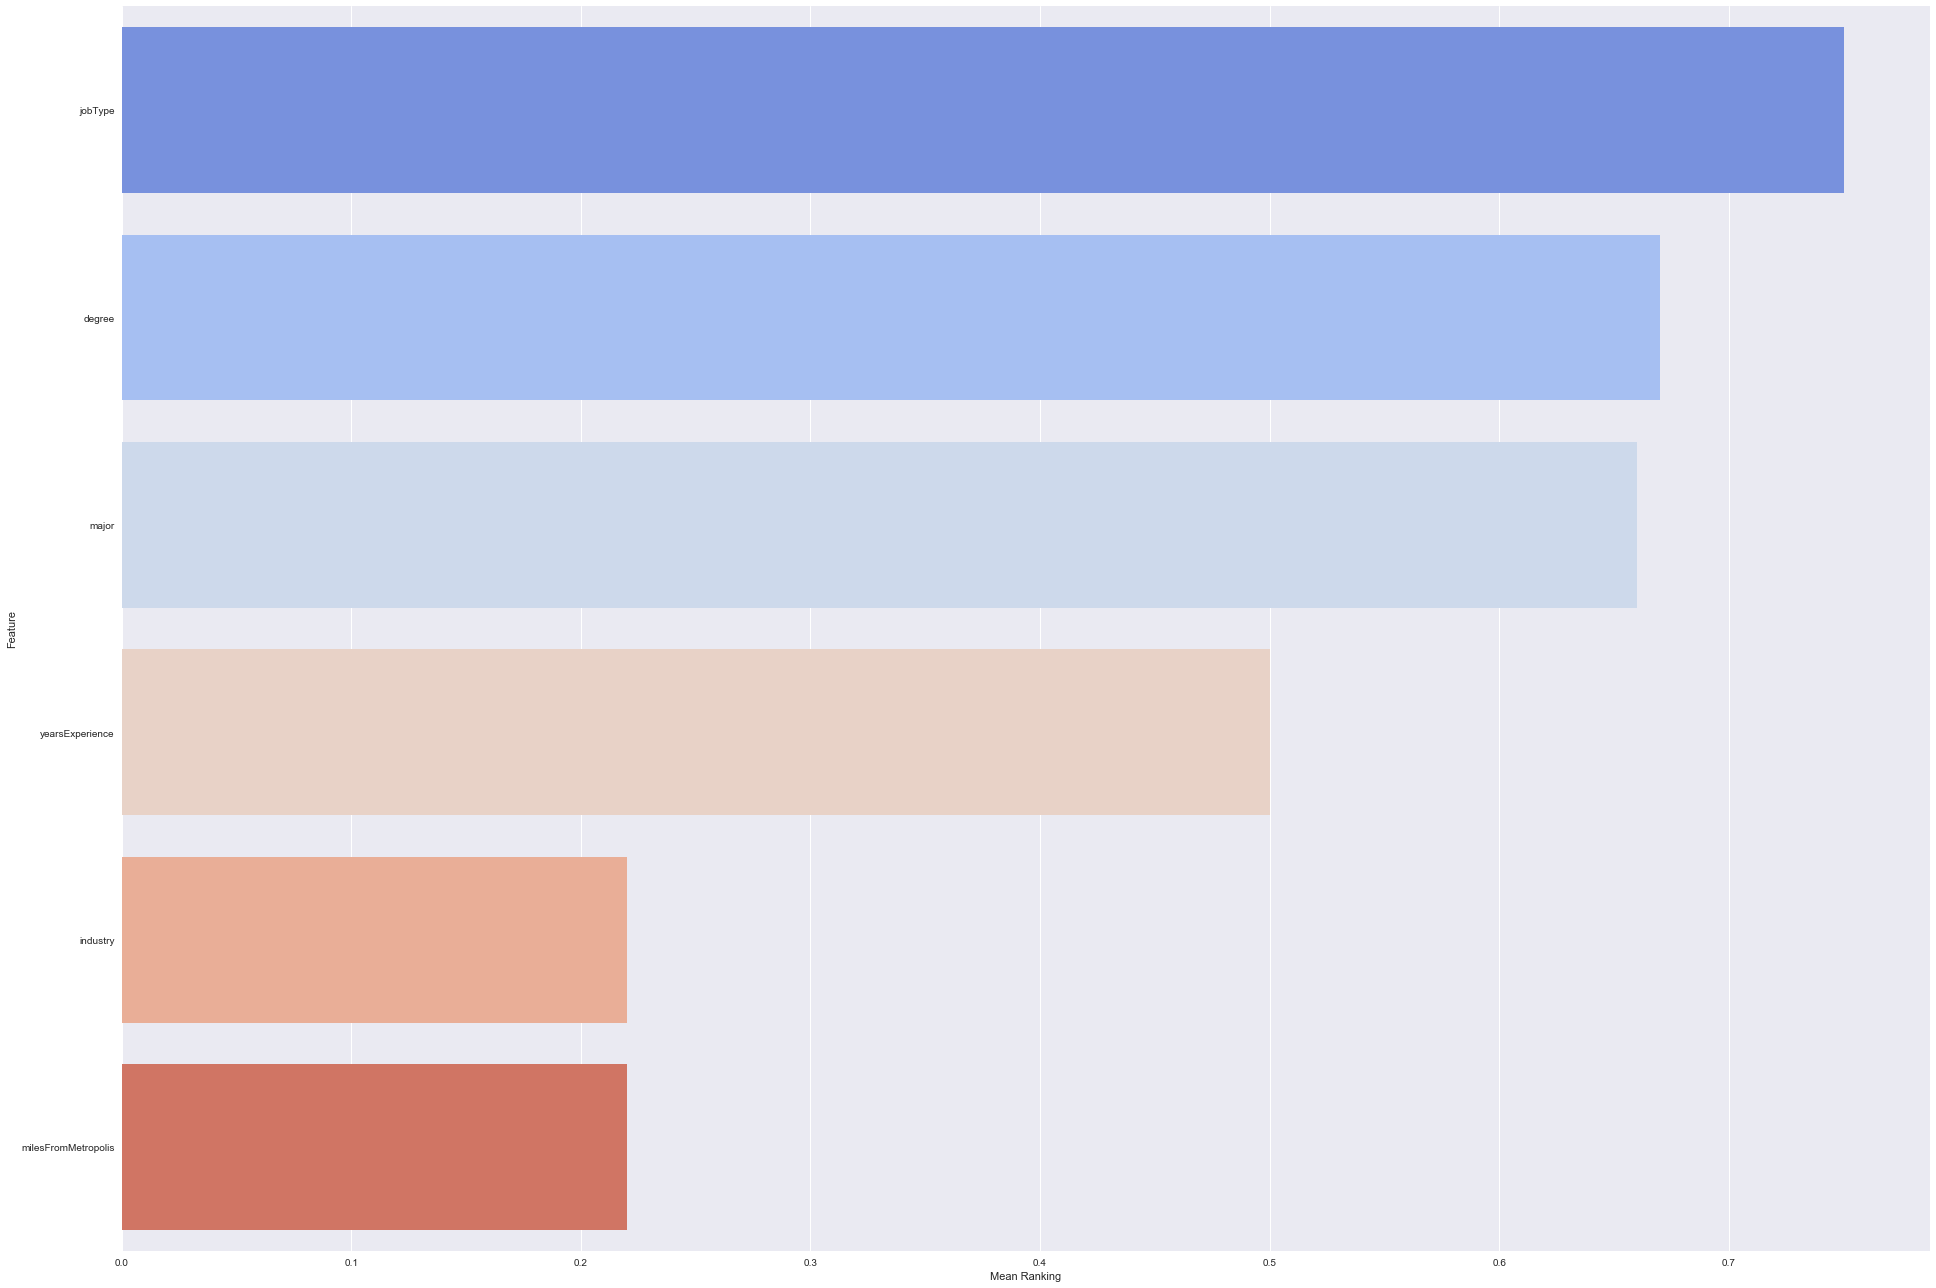

In [21]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=18, aspect=1.5, palette='coolwarm')

## Statistical Modelling

In [8]:
features = df[['jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis']]

In [9]:
features.head() # choosing just the features from the dataset which forms our X

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,1,3,6,3,10,83
1,0,2,7,6,3,73
2,7,1,8,3,10,38
3,5,1,2,0,8,17
4,7,0,8,2,8,16


In [10]:
target = df['salary'] # Labels or the outputs go into Y

In [11]:
target.head(5)

0    130
1    101
2    137
3    142
4    163
Name: salary, dtype: int64

## MLP Regressor: Multi-layer Perceptron (MLP) 

In [26]:
from sklearn.metrics import mean_squared_error
import sklearn.cross_validation

C:\Users\Akshay\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
from sklearn.neural_network import MLPRegressor

In [28]:
mlp=  MLPRegressor(activation='logistic',batch_size=50,hidden_layer_sizes=(600,), verbose=5,early_stopping=True)

In [30]:
kfold = KFold(n_splits=5, random_state=757)
results = cross_val_score(mlp, features, target, cv=kfold, scoring='neg_mean_squared_error')
print("Results: %.2f (%.2f) MSE" % (-results.mean(), results.std()))

Iteration 1, loss = 418.17054134
Validation score: 0.602590
Iteration 2, loss = 276.21980988
Validation score: 0.648137
Iteration 3, loss = 253.31591010
Validation score: 0.672333
Iteration 4, loss = 242.56899342
Validation score: 0.677624
Iteration 5, loss = 237.52584439
Validation score: 0.688709
Iteration 6, loss = 234.44804859
Validation score: 0.690858
Iteration 7, loss = 232.03636917
Validation score: 0.691787
Iteration 8, loss = 229.76796929
Validation score: 0.697817
Iteration 9, loss = 227.45192111
Validation score: 0.696221
Iteration 10, loss = 224.96584156
Validation score: 0.702494
Iteration 11, loss = 222.64131537
Validation score: 0.697095
Iteration 12, loss = 220.62772355
Validation score: 0.708192
Iteration 13, loss = 218.94029475
Validation score: 0.709891
Iteration 14, loss = 217.53543913
Validation score: 0.710587
Iteration 15, loss = 216.04921780
Validation score: 0.710792
Iteration 16, loss = 214.77035578
Validation score: 0.715827
Iteration 17, loss = 213.60088329

## Gradient Boosting Regression

In [31]:
import math
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 500, max_depth = 5,
          learning_rate = .1, loss = 'ls', verbose=3, random_state=77)

In [32]:

kfold = KFold(n_splits=5, random_state=767)
results = cross_val_score(clf, features, target, cv=kfold, scoring='neg_mean_squared_error')
print("Results: %.2f (%.2f) MSE" % (-results.mean(), results.std()))

      Iter       Train Loss   Remaining Time 
         1        1336.8012           16.51m
         2        1205.0262           15.30m
         3        1096.8926           14.71m
         4        1005.8883           14.53m
         5         929.9925           14.46m
         6         866.8375           14.30m
         7         813.3215           14.19m
         8         768.3073           14.09m
         9         729.6057           13.98m
        10         696.2537           13.97m
        11         666.8508           14.05m
        12         641.4914           14.00m
        13         619.4575           13.88m
        14         600.1709           13.81m
        15         581.3344           13.74m
        16         566.5323           13.68m
        17         551.8105           13.62m
        18         538.1633           13.56m
        19         527.5828           13.55m
        20         517.0079           13.52m
        21         508.4550           13.45m
        2

## Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


In [14]:
rfr=RandomForestRegressor(n_estimators=10,verbose=3,random_state=786) ## Vary the n_estimators to measure the change in error.
rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=786,
           verbose=3, warm_start=False)

In [15]:
kfold = KFold(n_splits=5, random_state=786)
results = cross_val_score(rfr, features, target, cv=kfold, scoring='neg_mean_squared_error')
print("Results: %.2f (%.2f) MSE" % (-results.mean(), results.std()))

building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Results: 472.84 (1.23) MSE


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


## DEEP LEARNING

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [38]:
fea=features.values

In [40]:
tar=target.values

In [49]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=6, kernel_initializer='normal', activation='linear'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [51]:
seed = 9
numpy.random.seed(seed)
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=10, batch_size=50, verbose=3)

In [52]:
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, fea, tar, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Results: 376.67 (5.29) MSE


## Few notes: 
## 1) Grid search can be performed for finding the best parameters but it is a computationally very expensive process and was taking alot of time to run on my machine.
## 2) PCA was also implemented but the results was absurd which is very intuitive after we look at our data which has more categorical variables.
## 3) Scaling was also performed but it did not improve our result therefore I used the original values in this script.

## Results:
## 1) With MLP regressor, the MSE is close to 390.
## 2) With Gradient Boosting Regressor, MSE is close to 355.
## 3) With Random Forest Regressor, MSE is close to 472.
## 4) With Deep Learning, MSE is close to 376.